In [1]:
import numpy as np
from partition_decode.models import ReluNetClassifier
from partition_decode.dataset import generate_gaussian_parity, recursive_gaussian_parity, generate_spirals, load_mnist
import torch

In [2]:
X, y = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=None, cov_scale=1.0
)

# X, y = recursive_gaussian_parity(
#     n_samples=1024, recurse_level=2, random_state=None, cov_scale=0.3
# )

# X, y = generate_spirals(
#     n_samples=1024, random_state=None, noise=0.7
# )

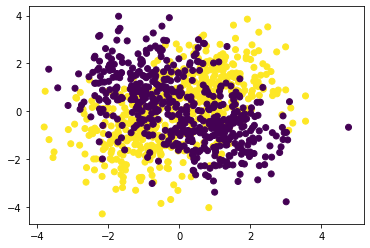

In [3]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [6]:
model = ReluNetClassifier(
    verbose=1, n_epochs=100, hidden_layer_dims=[100],
    learning_rate=0.01, early_stop_thresh=0)#, loss=torch.nn.BCEWithLogitsLoss)
model = model.fit(X, y)

Results for epoch 1, CrossEntropyLoss=0.61, 01_error=0.31
Results for epoch 6, CrossEntropyLoss=0.66, 01_error=0.41
Results for epoch 11, CrossEntropyLoss=0.60, 01_error=0.34
Results for epoch 16, CrossEntropyLoss=0.46, 01_error=0.19
Results for epoch 21, CrossEntropyLoss=0.65, 01_error=0.34
Results for epoch 26, CrossEntropyLoss=0.52, 01_error=0.25
Results for epoch 31, CrossEntropyLoss=0.47, 01_error=0.25
Results for epoch 36, CrossEntropyLoss=0.45, 01_error=0.25
Results for epoch 41, CrossEntropyLoss=0.45, 01_error=0.22
Results for epoch 46, CrossEntropyLoss=0.54, 01_error=0.31
Results for epoch 51, CrossEntropyLoss=0.48, 01_error=0.31
Results for epoch 56, CrossEntropyLoss=0.71, 01_error=0.31
Results for epoch 61, CrossEntropyLoss=0.48, 01_error=0.22
Results for epoch 66, CrossEntropyLoss=0.41, 01_error=0.16
Results for epoch 71, CrossEntropyLoss=0.35, 01_error=0.09
Results for epoch 76, CrossEntropyLoss=0.53, 01_error=0.25
Results for epoch 81, CrossEntropyLoss=0.45, 01_error=0.28

## Get region affine function

[d] * [d, d2] * relu * [d2, k] -> [k]

[d] * [d, d2] * [d2, d2] * [d2, k] -> [n, k]

[n, d] * [d, d2]


$y = W (relu (Wx + b)) + b = [W, b] [relu(Wx + b), 1] = [W, b] [R(Wx + b), 1] = [W, b] [RWx + Rb, 1] = WRWx + (WRb + b)$

In [42]:
act_relus

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0])

In [45]:
with torch.no_grad():
    print(np.hstack((
        module.weight.numpy(),
        module.bias.reshape(-1, 1).numpy()
    )).T.shape)

(101, 2)


In [68]:
x = X[1]# .reshape(1, -1)
W = np.eye(x.shape[-1]) # account for bias
b = np.zeros(x.shape[-1])
with torch.no_grad():
    x_pred = torch.autograd.Variable(torch.from_numpy(x).float())
    for module in next(model.model_.modules()):
        x_pred = module(x_pred)
        
        if type(module) == torch.nn.modules.activation.ReLU:
            act_relus = (x_pred.numpy() > 0).astype(int)
            layer_w = np.diag(act_relus)
            layer_b = 0
        else:
            layer_w = module.weight.numpy().T
            layer_b = module.bias.numpy()
            
        W =  W @ layer_w
        b =  b @ layer_w + layer_b

np.testing.assert_array_almost_equal(x_pred, x @ W + b)

In [78]:
irm = []
for x in X:
    W = np.eye(x.shape[-1]) # account for bias
    b = np.zeros(x.shape[-1])
    sample_rep = []
    with torch.no_grad():
        x_pred = torch.autograd.Variable(torch.from_numpy(x).float())
        for module in next(model.model_.modules()):
            x_pred = module(x_pred)

            if type(module) == torch.nn.modules.activation.ReLU:
                act_relus = (x_pred.numpy() > 0).astype(int)
                layer_w = np.diag(act_relus)
                layer_b = 0
            else:
                layer_w = module.weight.numpy().T
                layer_b = module.bias.numpy()

            W =  W @ layer_w
            b =  b @ layer_w + layer_b

            np.testing.assert_array_almost_equal(x_pred, x @ W + b)

            if type(module) == torch.nn.modules.activation.ReLU:
                sample_rep.append(np.linalg.norm(W, ord=2, axis=0))
    irm.append(np.hstack(sample_rep))
irm = np.vstack(irm)

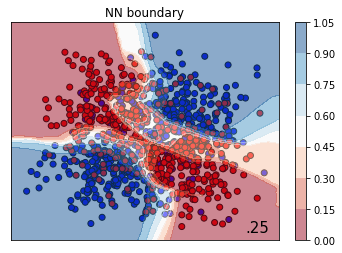

In [144]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(1, 1, 1)

# Plot the training points
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors="k")
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

score = net.score(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
Z = net.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=0.5)

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('NN boundary')
ax.text(
    xx.max() - 0.3,
    yy.min() + 0.3,
    ("%.2f" % score).lstrip("0"),
    size=15,
    horizontalalignment="right",
)
plt.colorbar()
plt.show()

In [145]:
irm = net.get_internal_representation(X, penultimate=False)

## Parameter impute

In [142]:
X_train, y_train = generate_gaussian_parity(
    n_samples=1024, angle_params=0, random_state=None, cov_scale=1.0
)

# X, y = recursive_gaussian_parity(
#     n_samples=1024, recurse_level=2, random_state=None, cov_scale=0.3
# )

# X, y = generate_spirals(
#     n_samples=1024, random_state=None, noise=0.7
# )

In [143]:
model = ReluNetClassifier(
    verbose=1, n_epochs=10, hidden_layer_dims=[10],
    learning_rate=0.01, early_stop_thresh=0)#, loss=torch.nn.BCEWithLogitsLoss)

In [144]:
model = model.fit(X_train, y_train)
with torch.no_grad():
    print(np.mean(y_train == model.predict(X_train)))

# model.n_epochs = 0
# model._train_model(X_train, y_train)
# print(np.mean(y_train == model.predict(X_train)))

Results for epoch 1, CrossEntropyLoss=0.73, 01_error=0.50
Results for epoch 6, CrossEntropyLoss=0.49, 01_error=0.23
0.7373046875


In [145]:
new_model = ReluNetClassifier(verbose=1, n_epochs=0, hidden_layer_dims=[20],
    learning_rate=0.01, early_stop_thresh=0
)
new_model._build_model(X_train.shape[-1], len(np.unique(y_train)))
with torch.no_grad():
    for prior_layer, new_layer in zip(model.model_, new_model.model_,):
        if isinstance(new_layer, torch.nn.ReLU):
            continue
        width, depth = prior_layer.weight.shape
        new_layer.weight[:width, :depth] = prior_layer.weight
        new_layer.bias[:width] = prior_layer.bias

new_model._train_model(X_train, y_train)

In [146]:
print(np.mean(y_train == new_model.predict(X_train)))

0.73046875


In [147]:
new_model.model_[0].weight

Parameter containing:
tensor([[-0.6229,  0.6128],
        [-0.2899,  0.2469],
        [ 0.6234, -0.0520],
        [-0.6382,  0.6064],
        [ 0.6041,  0.8540],
        [-0.2757,  0.3778],
        [ 0.0388,  0.1128],
        [-0.9102, -0.5263],
        [-0.6184,  0.3038],
        [-0.1628, -0.6668],
        [ 0.0841, -0.1184],
        [ 0.2108, -0.3145],
        [ 0.0176,  0.5059],
        [ 0.2708,  0.3724],
        [ 0.3626, -0.2471],
        [-0.0148,  0.2273],
        [ 0.3343, -0.2632],
        [-0.0415,  0.4311],
        [ 0.4919, -0.2792],
        [-0.0914,  0.4419]], requires_grad=True)

In [148]:
model.model_[0].weight

Parameter containing:
tensor([[-0.6229,  0.6128],
        [-0.2899,  0.2469],
        [ 0.6234, -0.0520],
        [-0.6382,  0.6064],
        [ 0.6041,  0.8540],
        [-0.2757,  0.3778],
        [ 0.0388,  0.1128],
        [-0.9102, -0.5263],
        [-0.6184,  0.3038],
        [-0.1628, -0.6668]], requires_grad=True)

In [129]:
model.model_

Sequential(
  (linear0): Linear(in_features=2, out_features=10, bias=True)
  (relu0): ReLU()
  (linear1): Linear(in_features=10, out_features=2, bias=True)
)

## Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from partition_decode.metrics import mse_classification

In [52]:
n_train = 1000
X_train, y_train = load_mnist(
    n_samples=n_train, save_path="/mnt/ssd3/ronan/pytorch", train=True, onehot=False
)

In [53]:
y_train.shape

(1000,)

In [54]:
model = RandomForestClassifier(n_estimators=2, max_depth=None, bootstrap=False)
model.fit(X_train, y_train)
y_train_pred = model.predict_proba(X_train)

In [55]:
np.unique(y_train_pred)

array([0., 1.])

In [56]:
mse_classification(y_train, y_train_pred)

0.0

In [57]:
y_train_pred[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [36]:
z = np.asarray([[0, 1], [1, 0]])

In [37]:
z[np.arange(z.shape[0]), np.asarray([0, 1])] -= 1

In [41]:
np.linalg.norm(z, axis=1)

array([1.41421356, 1.41421356])

In [40]:
np.linalg.norm(z[0])

1.4142135623730951